# Variational AutoEncoder (VAE)

### Step 1 - Import libraries

In [1]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
import plotly
import plotly.express as px # for data visualization
print('plotly: %s' % plotly.__version__) # print version

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

Tensorflow/Keras: 2.7.0
numpy: 1.21.4
matplotlib: 3.5.1
graphviz: 0.19.1
plotly: 5.4.0


### Step 2 - Load MNIST digit data

Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


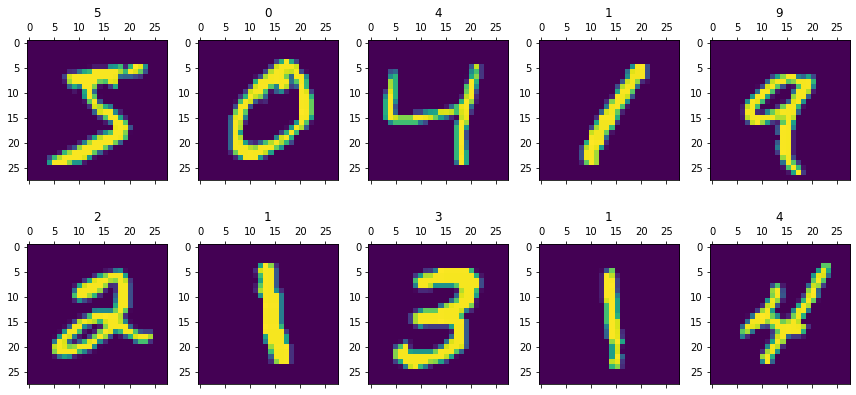

In [2]:
# Load digits data 
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

# Normalize input data (divide by 255) 
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show() 

##### Reshape input data (flatten images)

In [3]:
# Reshape input data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# Print shapes
print("New shape of X_train: ", X_train.shape)
print("New shape of X_test: ", X_test.shape)

New shape of X_train:  (60000, 784)
New shape of X_test:  (10000, 784)


### Step 3 - Build a Variational Autoencoder model

##### Define a function to be used for Z-sampling

We use a reparameterization trick which allows the loss to backpropagate through the mean and variance nodes since they are deterministic while separating the sampling node by adding a non-deterministic parameter epsilon. This makes z deterministic and backpropagation works like a charm. The epsilon can be thought of as a random noise used to maintain the required stochasticity of z. Here the epsilon is sampled from a standard normal distribution ( mean=0., stddev=1. ).

In [40]:
#--- Create a function, which we will use to randomly sample from latent space distribution
# Note, epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
# Meanwhile, z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers.
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

##### Create Encoder model

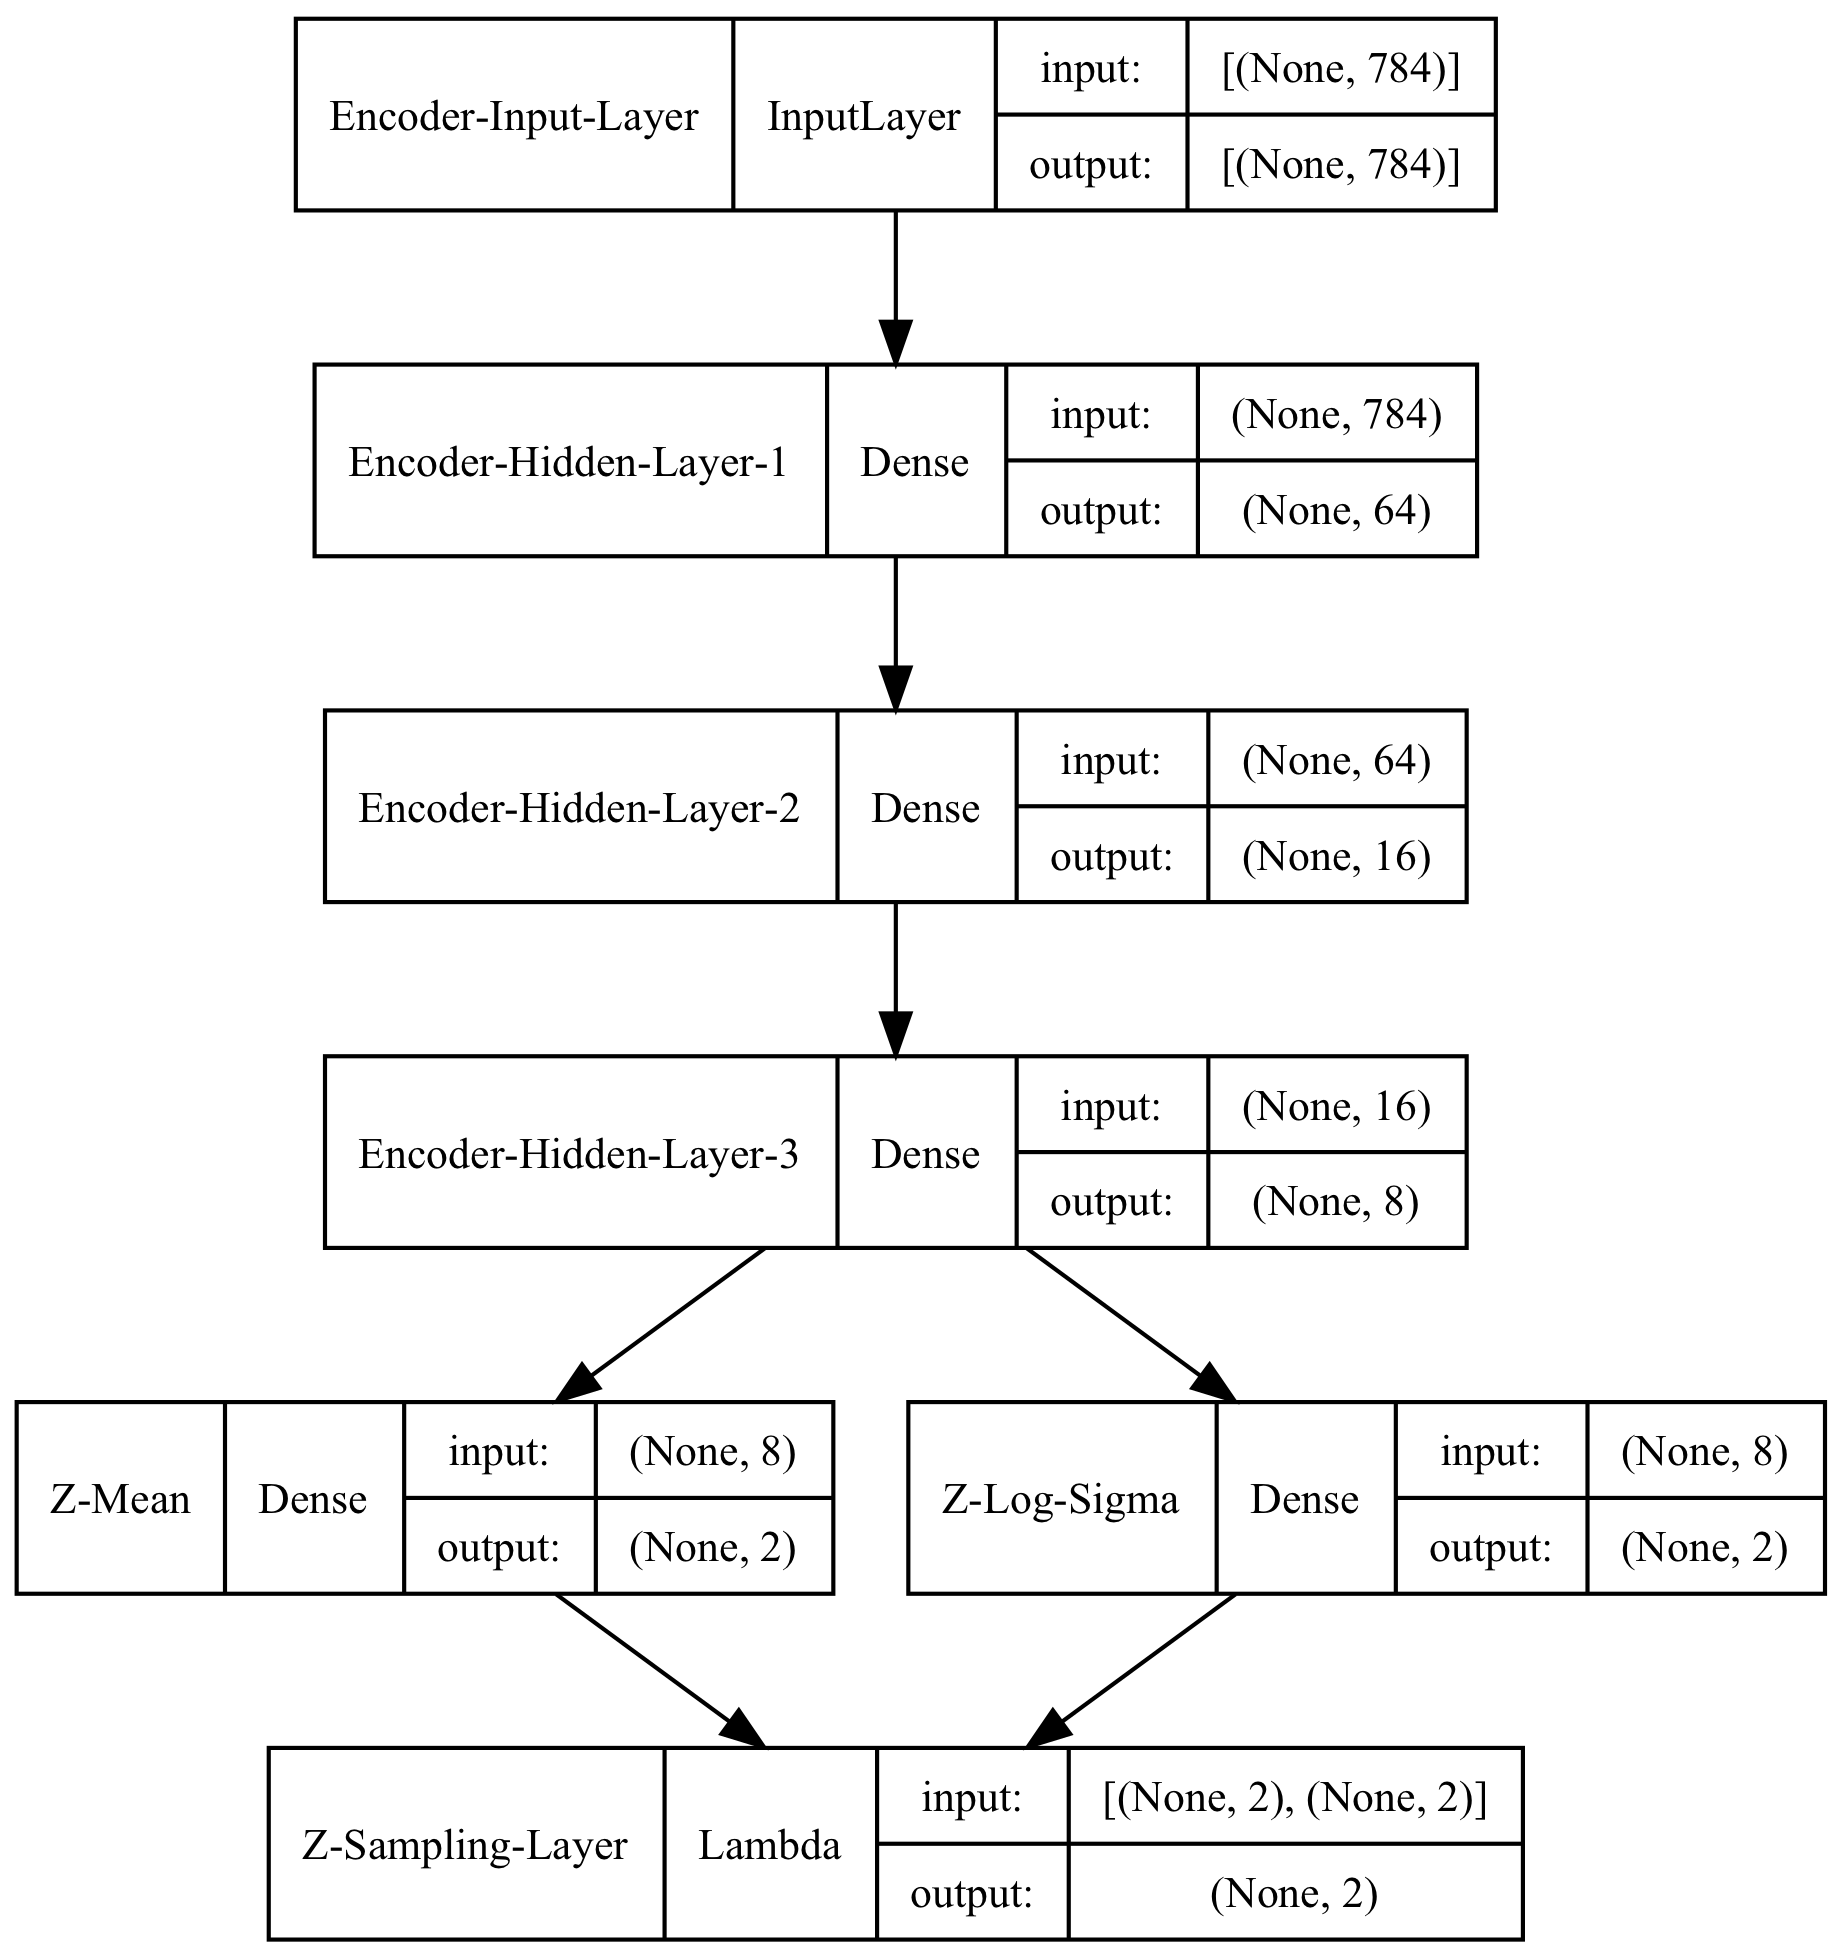

In [41]:
# Specify dimensions for input/output and latent space layers
original_dim = 784 # number of neurons at the input layer (28 * 28 = 784)
latent_dim = 2 # latent space dimension

# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
plot_model(encoder, show_shapes=True, dpi=300)
#plot_model(encoder, to_file=main_dir+'/pics/Encoder.png', show_shapes=True, dpi=300)

##### Create a decoder model

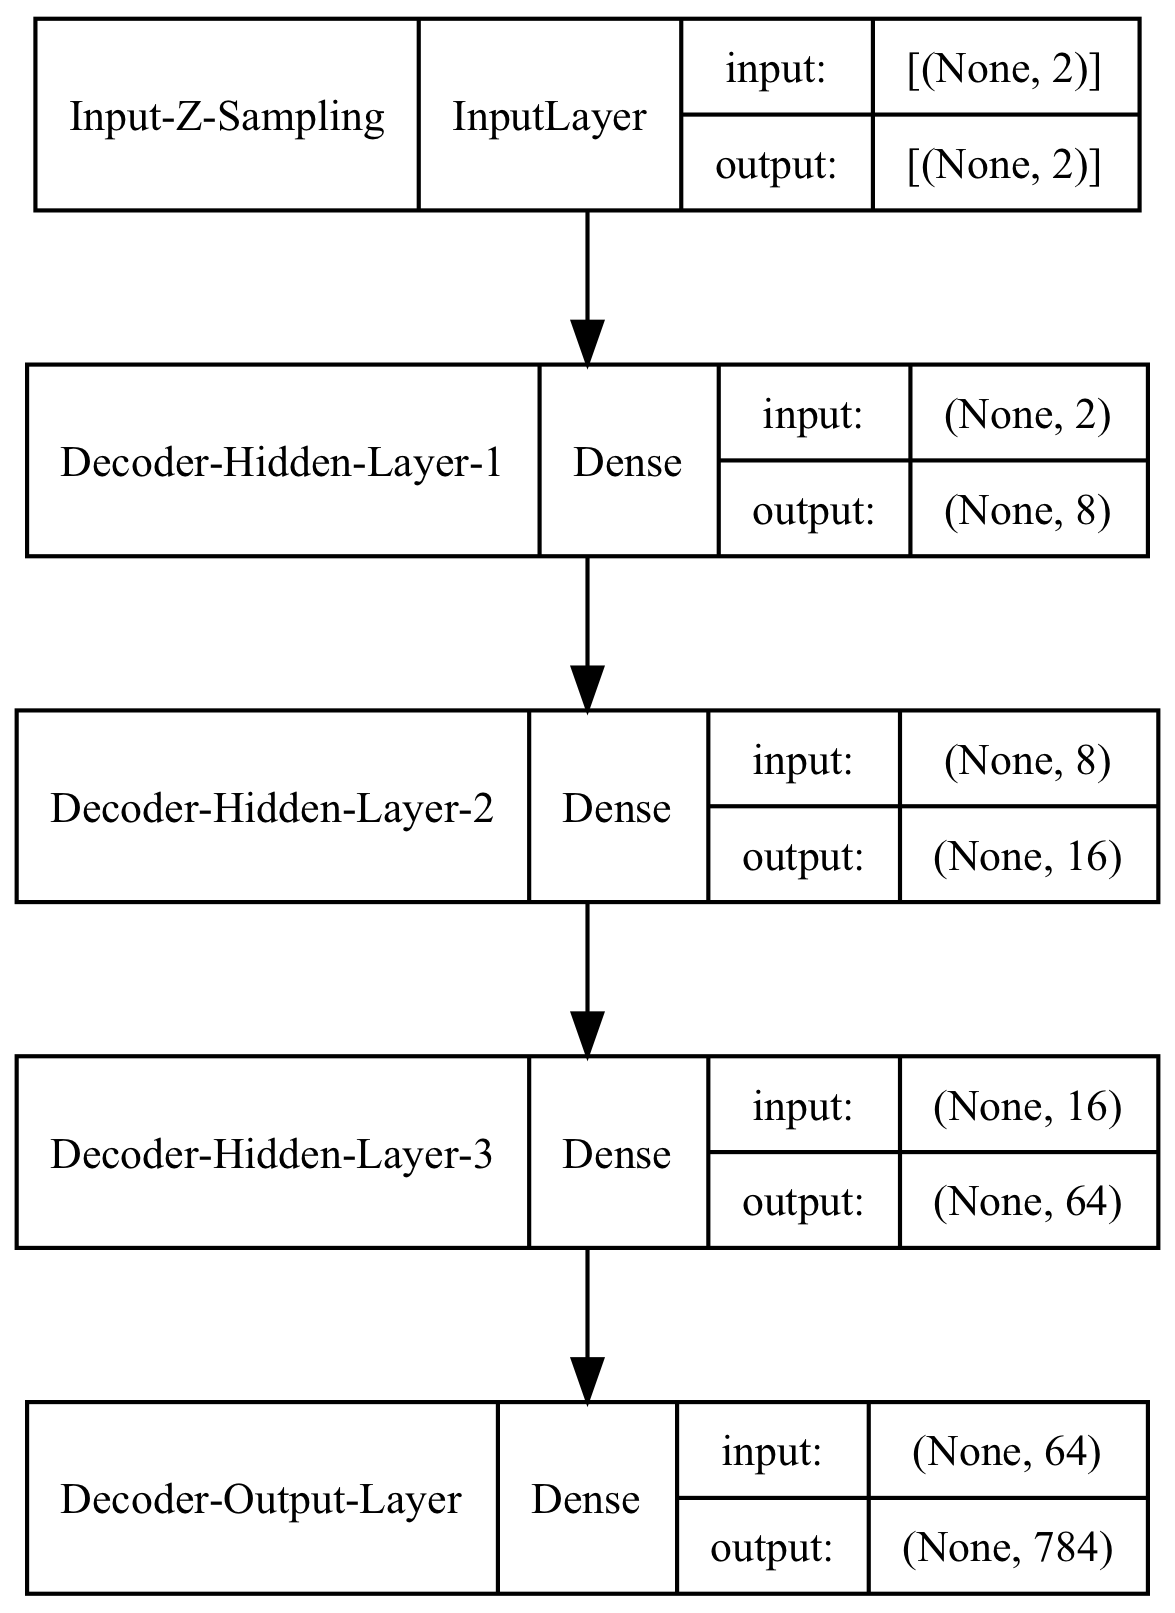

In [42]:
# ********** Create Decoder **********

#--- Input Layer (from the latent space)
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
plot_model(decoder, show_shapes=True, dpi=300)
#plot_model(decoder, to_file=main_dir+'/pics/Decoder.png', show_shapes=True, dpi=300)

In [43]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

##### Custom loss function

If the encoder outputs encoding Z far from a standard normal distribution, KL-divergence loss will penalize it more. The KL-divergence acts as a regularizer, which keeps the encodings Z sufficiently diverse. If we omitted the regularizer, the encoder could learn to cheat and give each datapoint an encoding in a different Euclidean space region. In other words, KL divergence optimizes the probability distribution parameters \mu and \sigma to closely resemble the unit Gaussian distribution N(0, 1).

In [44]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

##### Train VAE model

In [45]:
history = vae.fit(X_train, X_train, epochs=25, batch_size=16, validation_data=(X_test, X_test))

Epoch 1/25
3750/3750 [==============================] - 9s 2ms/step - loss: 47.5233 - val_loss: 42.0845
Epoch 2/25
3750/3750 [==============================] - 7s 2ms/step - loss: 40.4765 - val_loss: 39.5366
Epoch 3/25
3750/3750 [==============================] - 7s 2ms/step - loss: 38.7505 - val_loss: 38.3313
Epoch 4/25
3750/3750 [==============================] - 7s 2ms/step - loss: 37.7601 - val_loss: 37.4831
Epoch 5/25
3750/3750 [==============================] - 7s 2ms/step - loss: 37.0385 - val_loss: 36.8785
Epoch 6/25
3750/3750 [==============================] - 7s 2ms/step - loss: 36.5235 - val_loss: 36.4114
Epoch 7/25
3750/3750 [==============================] - 7s 2ms/step - loss: 36.1155 - val_loss: 36.0101
Epoch 8/25
3750/3750 [==============================] - 8s 2ms/step - loss: 35.8205 - val_loss: 35.9739
Epoch 9/25
3750/3750 [==============================] - 7s 2ms/step - loss: 35.5950 - val_loss: 35.6400
Epoch 10/25
3750/3750 [==============================] - 7s 2ms/

##### Plot a loss chart

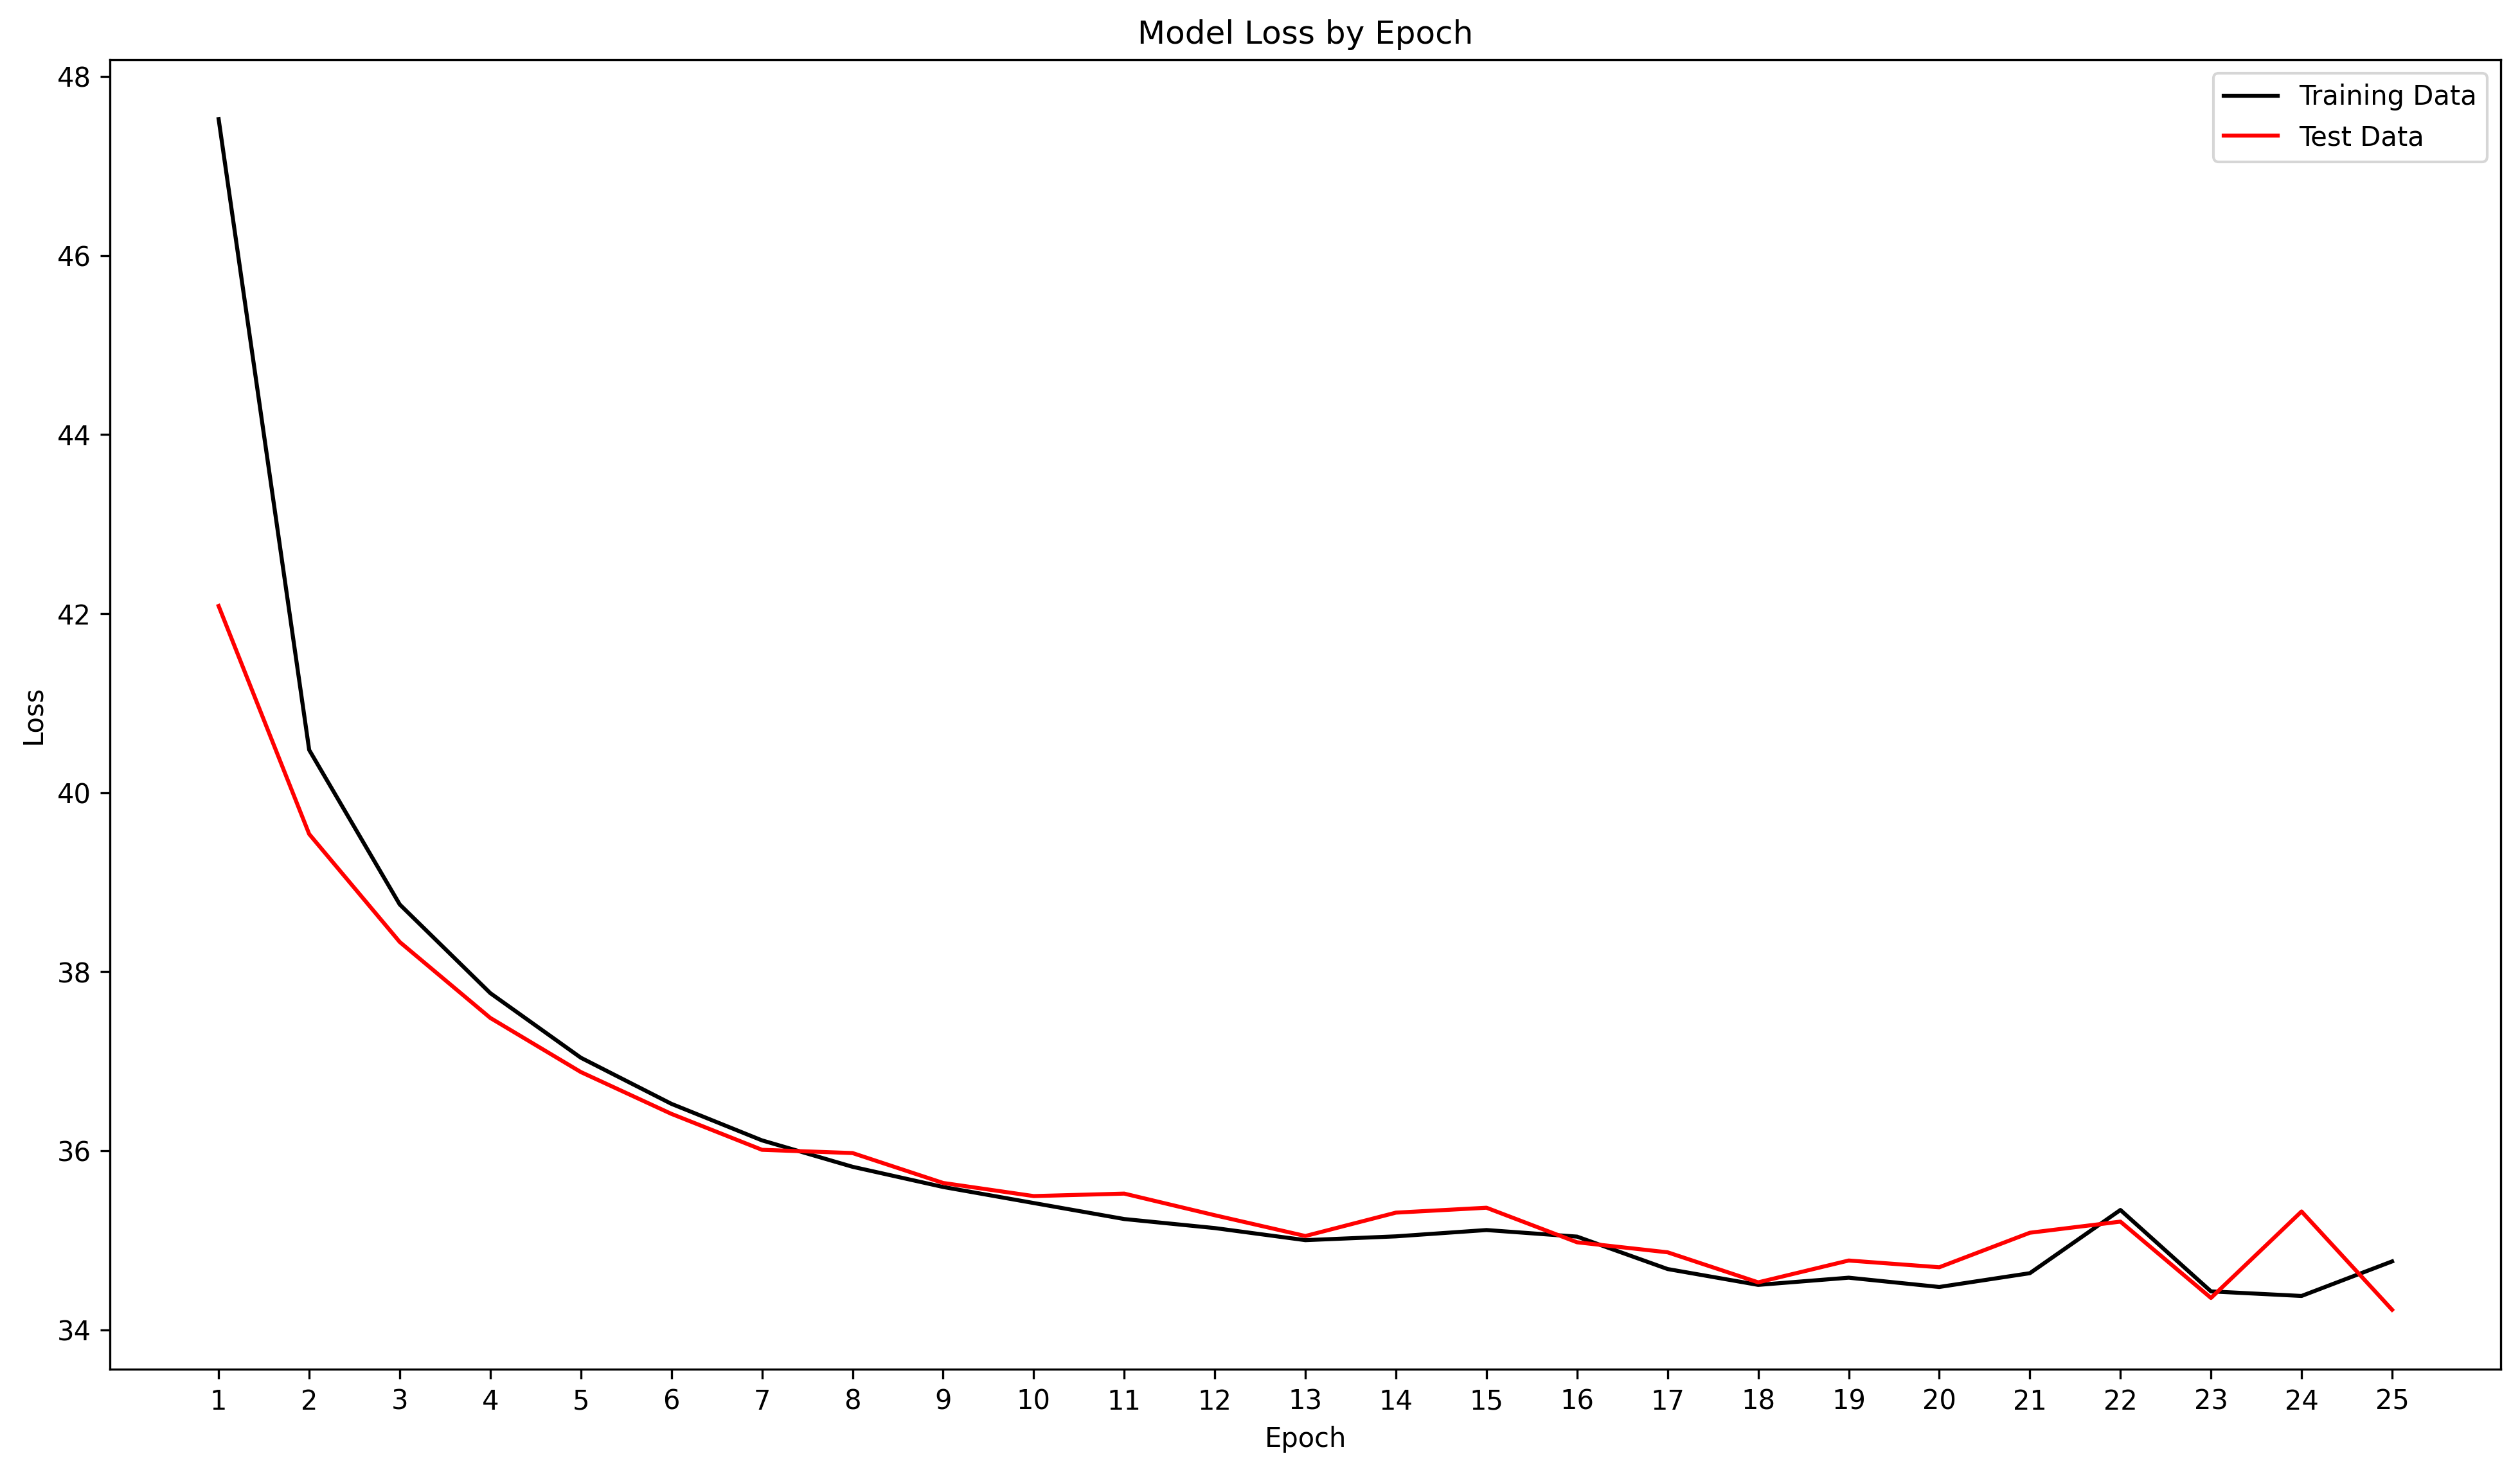

In [46]:
# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()

plt.show()

##### Visualize latent space

Because our latent space is two-dimensional, we can visualize the neighborhoods of different digits on the latent 2D plane:

In [103]:
# Use encoder model to encode inputs into a latent space
X_test_encoded = encoder.predict(X_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
# Create a scatter plot
fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
                 opacity=1, color=y_test.astype(str))

# Change chart background color and dimensions
fig.update_layout(dict(plot_bgcolor = 'white'), margin=dict(l=0, r=0, t=40, b=0))
#, width=1000, height=800)

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
fig.update_layout(title_text="MNIST digit representation in the 2D Latent Space")

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

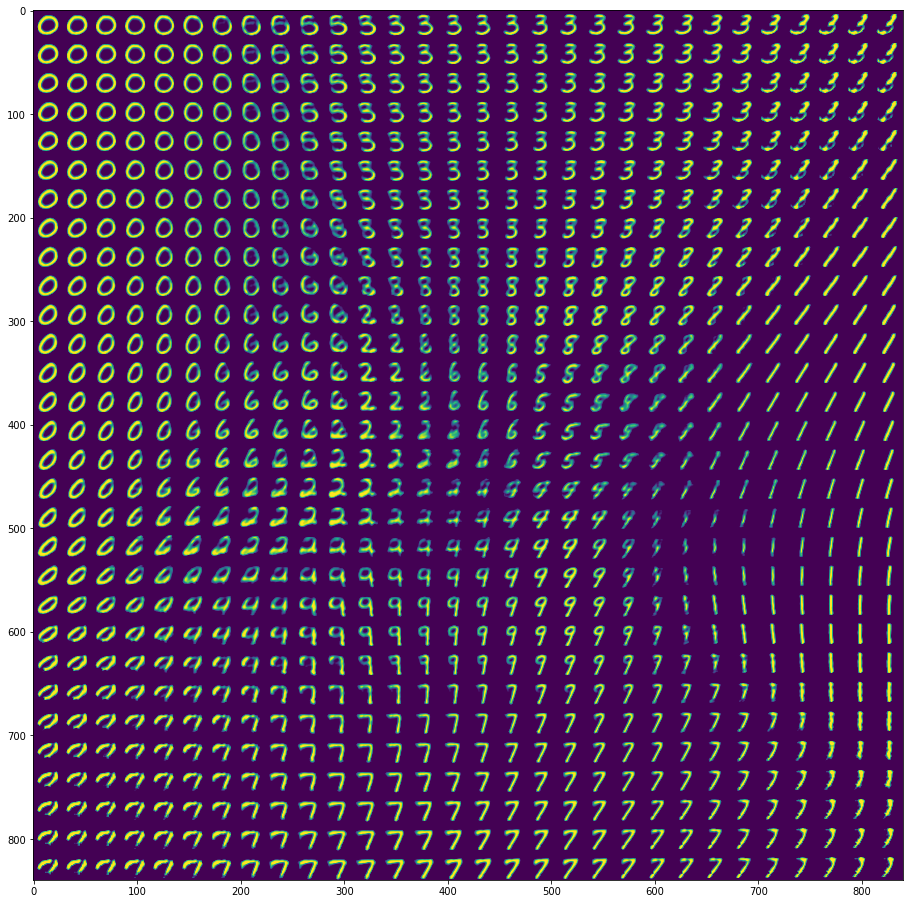

In [112]:
# Display a 2D manifold of the digits
n = 30  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-2.5, 2.5] standard deviations
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Generate an image using a decoder model
        x_decoded = decoder.predict(z_sample)
        x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker
        # Reshape from 784 to original digit size (28x28)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot figure
plt.set_facecolor('xkcd:salmon')
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

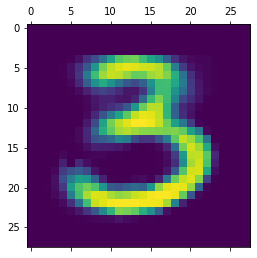

In [106]:
# Input latent space coordinates
z_sample_digit=[[0,2.5]]

# Decode latent inputs (i.e., generate new outputs)
digit_decoded = decoder.predict(z_sample_digit)

# Reshape and display the image
plt.matshow(digit_decoded.reshape(28,28))
plt.show()

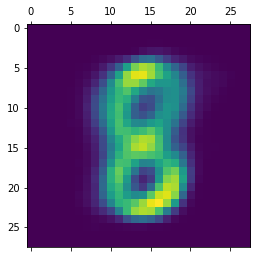

In [107]:
# Input latent space coordinates
z_sample_digit=[[0,0.4]]

# Decode latent inputs (i.e., generate new outputs)
digit_decoded = decoder.predict(z_sample_digit)

# Reshape and display the image
plt.matshow(digit_decoded.reshape(28,28))
plt.show()

# End of Program